# Part 2 (A7) - D: Product Description Analysis

Taso Kinnas

Carry out your proposed research! At the end of this, submit:

* A 5–10 page report with your research questions and results. This should be organized to communicate, without attention to the order in which things need to be run.

* An HTML export of your Jupyter notebook that contains the actual analysis. All figures from your report should appear in this document, in their appropriate computational context.

Notes:  
consider k-means for clustering...
Pearson correlation


 look at
 - splitting out multiple notebooks
 - swap memory (op sys takes care of)
 - write csv and save() and load() for data management with R

 consider consolidatung categories(5-10)
 contour plot (discount, length of time, consider looking at percrnt change in price), ggplot (see Dr. E example on rat tumor)
 heat map

In [1]:
library(tidyverse) # general tidyverse functions
library(modelr) # for calculating results from models
library(tidytext) # for tokenizing words
library(stringr) # tidy texting helpers
library(tidyr)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
# sets plot height to 3.5 inches
options(repr.plot.height=3.5)

In [3]:
# function to export plots
make.plot = function(name, plot_expr, type="pdf", width, height, ...) {
    dir.create("data/wholefoods/images", recursive = TRUE, showWarnings = FALSE)
    if (identical(type, "pdf")) {
        pdf(sprintf("data/wholefoods/images/%s.pdf", name),
            width=width, height=height, ...)
    } else if (identical(type, "png")) {
        png(sprintf("data/wholefoods/images/%s.png", name),
            width=width, height=height, units="in", res=300, ...)
    } else {
        stop("invalid plot type")
    }
    print(plot_expr)
    dev.off()
    plot_expr
}

In [4]:
#wfm = read_tsv('data/wholefoods/wfm_final.tsv', col_types="cccccccDddddcccc")
# filtered on region 7 (pacific northwest)
wfm = read_tsv('data/wholefoods/wfm_r7.zip', col_types="cccccccDddddcccc")
#Store 10564 appears to be a 'test' store of some sort.
wfm = wfm %>%
    filter(CustNum != 10564)
cats = read_csv('data/wholefoods/categories.csv', col_types="cccccc")

# load stop words for word parsing
data(stop_words)

spec(wfm)
spec(cats)

cols(
  Region = col_character(),
  CustNum = col_character(),
  Store = col_character(),
  Address = col_character(),
  City = col_character(),
  StateAbr = col_character(),
  zip = col_character(),
  Date = col_date(format = ""),
  Sales = col_double(),
  SalesLy = col_double(),
  Units = col_double(),
  UnitsLy = col_double(),
  Brand = col_character(),
  Category = col_character(),
  UPC = col_character(),
  Description = col_character()
)

cols(
  Family_01 = col_character(),
  Category_02 = col_character(),
  Subcategory_03 = col_character(),
  Class_04 = col_character(),
  UPC = col_character(),
  Product = col_character()
)

## 3. Data Summary:

In [5]:
summary(wfm)

    Region            CustNum             Store             Address         
 Length:987107      Length:987107      Length:987107      Length:987107     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
     City             StateAbr             zip                 Date           
 Length:987107      Length:987107      Length:987107      Min.   :2016-01-04  
 Class :character   Class :character   Class :character   1st Qu.:2016-04-04  
 Mode  :character   Mode  :character   Mode  :character   Median :2016-07-04  
                                                          Mean   :2016-07-03  
                                                          3rd Qu.:

In [6]:
wfm_cats = wfm %>%
    left_join(cats)

Joining, by = "UPC"


In [7]:
wfm_cats = wfm_cats %>%
    filter(Category_02 != "NA")

In [8]:
brandcat = wfm_cats %>%
    group_by(Family_01) %>%
    distinct(Brand) %>%
    select(-Brand) %>%
    summarize(count=n()) %>%
    arrange(-count) 
brandcat

Family_01,count
Grocery,28
Grocery Dairy,9
Grocery Frozen,9
Body Care,6
Grocery Bulk,6
Supplements,6
Beer,2
Unidentified Items,2
Bakery,1
Coffee,1


In [9]:
wfm_sales_by_category = wfm_cats %>%
    group_by(Category_02) %>%
    summarize(salesTY=sum(Sales), unitsTY=sum(Units), 
              salesLY=sum(SalesLy), unitsLY=sum(UnitsLy),
              CpU_TY=sum(Sales)/sum(Units), CpU_LY=sum(SalesLy)/sum(UnitsLy)) %>%
    arrange(-salesTY) %>%
    mutate(c_rank=row_number())
head(wfm_sales_by_category)

Category_02,salesTY,unitsTY,salesLY,unitsLY,CpU_TY,CpU_LY,c_rank
Salty Snacks,1285221,396416.0,1009596.0,319369,3.242102,3.161221,1
Cold Cereal,1283791,269393.0,1239820.6,264213,4.765495,4.692504,2
Refrigerated Functional Beverages,1244642,334619.0,1105115.6,307158,3.719580,3.597873,3
Beauty,1238967,132684.7,1279125.5,141083,9.337676,9.066478,4
Entrees,1171647,278963.0,995514.2,238320,4.200009,4.177216,5
Yogurt,1157245,478140.0,1072563.1,441462,2.420305,2.429571,6


In [10]:
wfm_sales_date_category = wfm_cats %>%  
    #filter(Family_01 == "Grocery Dairy") %>%
    group_by(Date, Category_02, Brand) %>%
    summarize(WsalesTY=sum(Sales), WunitsTY=sum(Units), 
              WsalesLY=sum(SalesLy), WunitsLY=sum(UnitsLy),
              WCpU_TY=sum(Sales)/sum(Units), WCpU_LY=sum(SalesLy)/sum(UnitsLy))
head(wfm_sales_date_category)

Date,Category_02,Brand,WsalesTY,WunitsTY,WsalesLY,WunitsLY,WCpU_TY,WCpU_LY
2016-01-04,Aromatherapy,EO,623.79,51.0,323.84,26.00,12.231176,12.455385
2016-01-04,Baking,Bob's Red Mill,1161.14,155.2,1169.91,198.49,7.481572,5.894050
2016-01-04,"Baking Mixes, Ingredients & Flours",Bob's Red Mill,12747.95,2265.0,13160.11,2340.00,5.628234,5.623979
2016-01-04,"Baking Mixes, Ingredients & Flours",Nature's Path,0.00,0.0,6.99,1.00,NaN,6.990000
2016-01-04,"Baking Mixes, Ingredients & Flours",Pamelas Products,2262.16,234.0,1960.55,199.00,9.667350,9.852010
2016-01-04,Bath and Body,Derma E,234.79,21.0,187.82,16.00,11.180476,11.738750


## 4. Do product/brand names have better sales values/does using certain words increase a product's sales effectiveness?

Tokenize words and remove common words

In [25]:
wfm_words = wfm_cats %>% 
    select(Category_02, UPC, Description) %>%
    collect() %>%
    unnest_tokens(word, Description)
head(wfm_words)

wfm_words = wfm_words %>%
    anti_join(stop_words)
head(wfm_words)

Category_02,UPC,word
Ethnic,70895360103,rice
Ethnic,70895360103,ramen
Ethnic,70895360103,millet
Ethnic,70895360103,and
Ethnic,70895360103,brown
Ethnic,70895360103,og


Joining, by = "word"


Category_02,UPC,word
Ethnic,70895360103,rice
Ethnic,70895360103,ramen
Ethnic,70895360103,millet
Ethnic,70895360103,brown
Ethnic,70895360103,og
Ethnic,70895360103,2.8oz


In [31]:
custom_words = grep(pattern="oz",word_count$word)
custom_words

[1]    3    4    6    8   12   14   17   19   21   25   27   35   44   59   65
 [16]   70   76   93   96   97  109  114  116  118  119  120  124  125  126  140
 [31]  147  158  160  161  182  199  209  216  218  219  232  239  241  246  256
 [46]  260  262  263  287  297  298  299  313  314  328  339  341  357  367  370
 [61]  376  392  404  411  453  475  481  489  504  519  520  521  525  529  531
 [76]  533  534  552  565  569  572  574  600  623  636  642  647  658  669  674
 [91]  684  685  702  719  735  752  773  778  779  782  793  817  844  861  866
[106]  885  910  911  914  923  936  938  975  989  993 1016 1034 1064 1087 1092
[121] 1095 1103 1110 1135 1219 1221 1229 1240 1265 1266 1295 1311 1335 1370 1391
[136] 1407 1413 1414 1465 1484 1493 1518 1527 1534 1562

In [32]:
wfm_words = wfm_words %>%
    anti_join(custom_words)
head(wfm_words)

ERROR: Error in UseMethod("tbl_vars"): no applicable method for 'tbl_vars' applied to an object of class "c('integer', 'numeric')"


In [26]:
word_count = wfm_words %>%
    count(word, sort = TRUE)
head(word_count)

word,n
og,433058
rice,143775
16oz,124364
32oz,62439
tea,53800
6oz,52834


In [28]:
# need control = "userid"
# looking at relative jumps in volume
#group by week anf look at week over week increase
category_units = wfm_sales_by_category %>%
    select(Category_02, c_rank) %>%
    inner_join(wfm_sales_date_category)# %>%
    #mutate(CpU = salesTY/unitsTY) %>%
head(category_units)

Joining, by = "Category_02"


Category_02,c_rank,Date,Brand,WsalesTY,WunitsTY,WsalesLY,WunitsLY,WCpU_TY,WCpU_LY
Salty Snacks,1,2016-01-04,Bob's Red Mill,183.54,46,87.78,22,3.990000,3.990000
Salty Snacks,1,2016-01-04,Late July,8424.80,2462,5051.06,1592,3.421933,3.172776
Salty Snacks,1,2016-01-04,Lundberg,11002.14,3647,13313.25,4389,3.016764,3.033322
Salty Snacks,1,2016-01-04,Nature's Path,4499.50,1320,0.00,0,3.408712,NaN
Salty Snacks,1,2016-01-04,Newmans Own Organics,893.76,224,757.59,199,3.990000,3.806985
Salty Snacks,1,2016-01-11,Bob's Red Mill,147.63,37,79.80,20,3.990000,3.990000


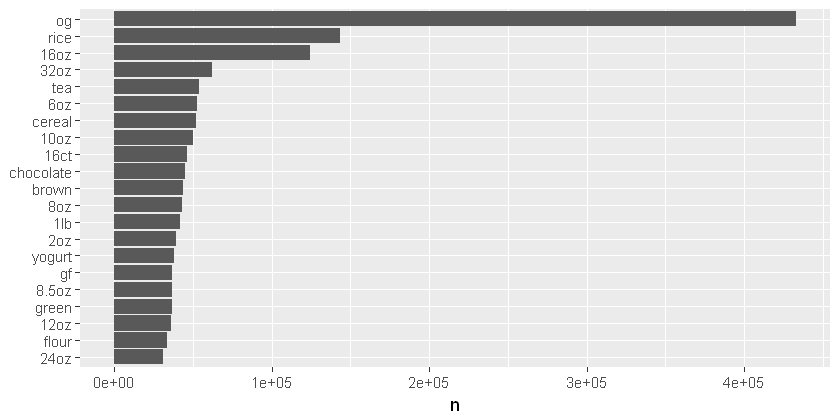

In [29]:
#ffilter on regex, maybe lgrep, filter on numoz
# consider clustering on text
word_plot = word_count %>%
  #count(word, sort = TRUE) %>%
  filter(n > 30000) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip()
word_plot

In [15]:
cat_words = wfm_words %>%   
    count(Category_02, word, sort = TRUE) %>%
    ungroup()

total_words = cat_words %>% 
    group_by(Category_02) %>% 
    summarize(total = sum(n))

all_words = cat_words %>%
    left_join(total_words)

head(all_words)

Joining, by = "Category_02"


Category_02,word,n,total
Cold Cereal,og,54144,388857
Cold Cereal,cereal,49048,388857
Packaged Teas,16ct,46289,229544
Packaged Teas,tea,38065,229544
Yogurt,yogurt,35208,184455
Packaged Teas,og,32248,229544


In [16]:
freq_by_rank = all_words %>% 
  group_by(Category_02) %>% 
  mutate(rank = row_number(), 
         term_frequency = n/total)
head(freq_by_rank)

Category_02,word,n,total,rank,term_frequency
Cold Cereal,og,54144,388857,1,0.1392388
Cold Cereal,cereal,49048,388857,2,0.1261338
Packaged Teas,16ct,46289,229544,1,0.2016563
Packaged Teas,tea,38065,229544,2,0.1658288
Yogurt,yogurt,35208,184455,1,0.1908758
Packaged Teas,og,32248,229544,3,0.1404872


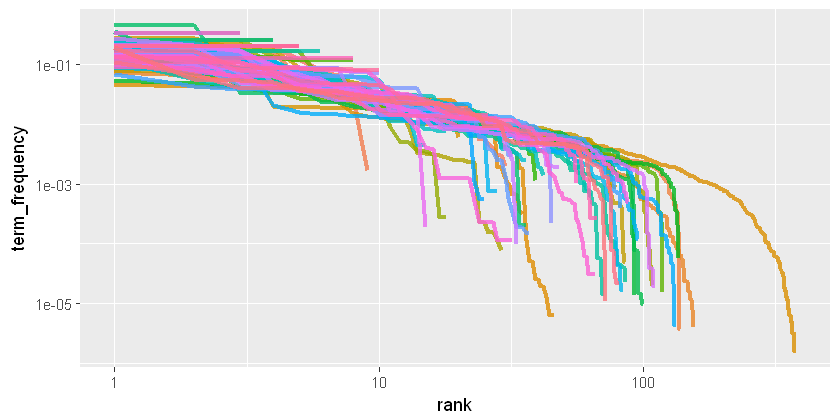

In [17]:
#look at sales volume by rank (product) 
#zipf's law, lol
zipf_plot = freq_by_rank %>% 
    ggplot(aes(rank, term_frequency, color = Category_02)) + 
    geom_line(size = 1.2, alpha = 0.8, show.legend = FALSE) + 
    scale_x_log10() +
    scale_y_log10()
zipf_plot

In [18]:
# words in products help boost sales against category sales